In [55]:
import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


SEED = 123

# Let's get the dataset

In [2]:
df = pd.read_csv('dataset_rw.csv')
df.head()

,Unnamed: 0,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,duration_out__fc,n_recipients__fc,...,mean__duration_in__tc__rw90,duration_in__fo__rw90,mean__duration_in__fo__rw90,duration_in__fc__x,duration_in__tc__x,duration_in__fo__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0,0063000000YvrLnAAJ,2022-11-30,False,2021-02-20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-20,2021Q3,2023Q2,False
1,1,0063000000bj6S6AAI,2021-08-16,False,2021-02-20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-20,2021Q3,2022Q1,False
2,2,0061300001ADuHtAAL,2022-08-29,False,2021-02-20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-20,2021Q3,2023Q1,False
3,3,0061300001B0UOaAAN,2021-06-08,False,2021-02-20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-20,2021Q3,2021Q4,False
4,4,0061300001B0qRQAAZ,2021-05-24,False,2021-02-20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-20,2021Q3,2021Q4,False


In [29]:
#train_columns = ['n__fc', 'n__tc', 'n__fo', 'mean_n_recipients__fc', 'mean_n_recipients__tc', 'mean_n_recipients__fo']
train_columns = ['n__fc__x', 'n__tc__x', 'n__fc__rw7', 'n__tc__rw7', 'n__fc__rw30', 'n__tc__rw30', 'n__fc__rw90', 'n__tc__rw90', 'duration_in__fc__rw7']
train_columns

['n__fc__x',
 'n__tc__x',
 'n__fc__rw7',
 'n__tc__rw7',
 'n__fc__rw30',
 'n__tc__rw30',
 'n__fc__rw90',
 'n__tc__rw90',
 'duration_in__fc__rw7']

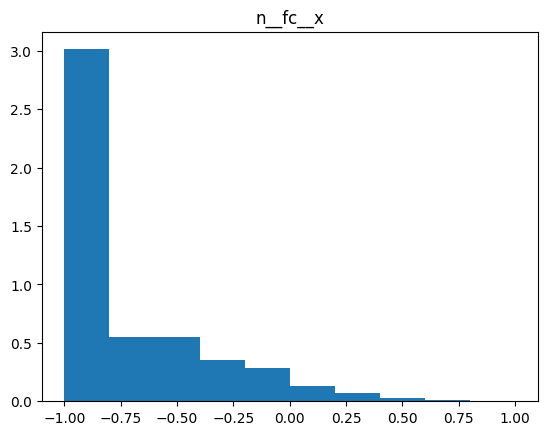

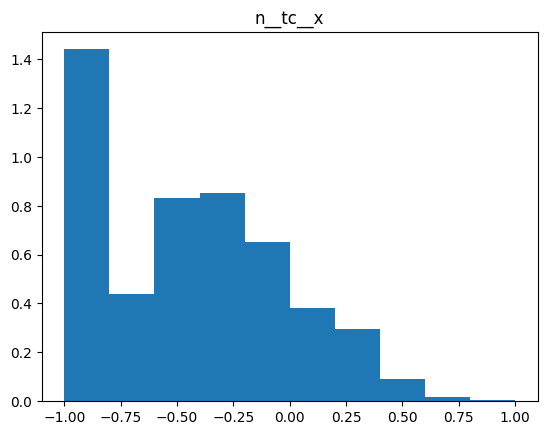

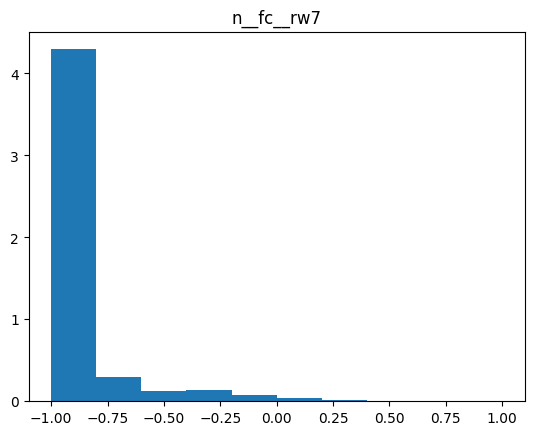

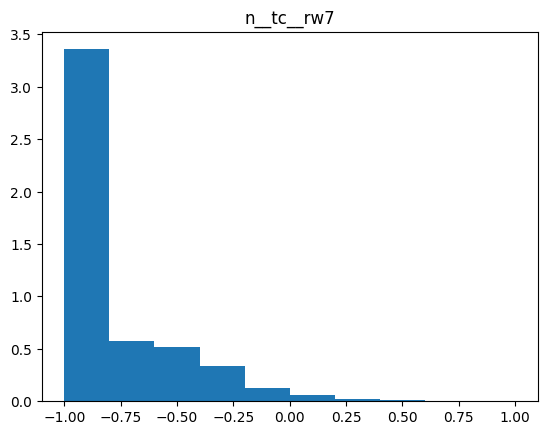

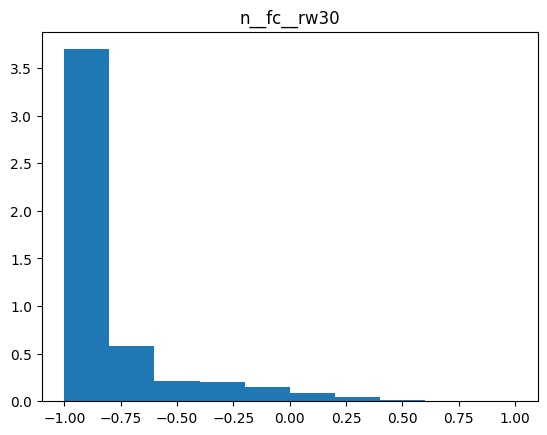

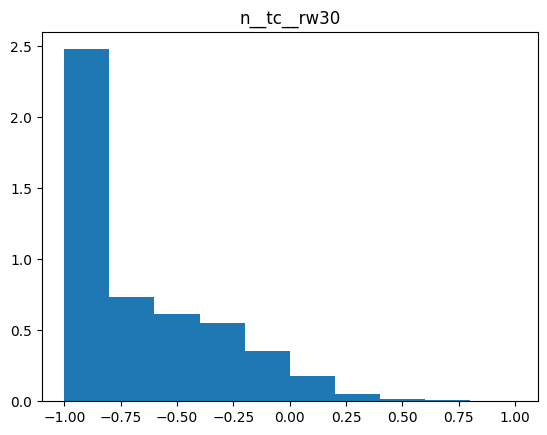

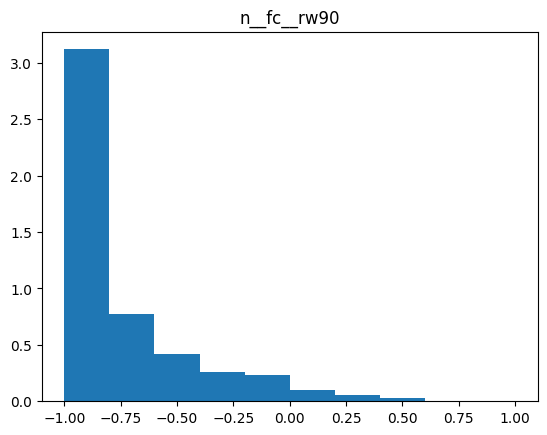

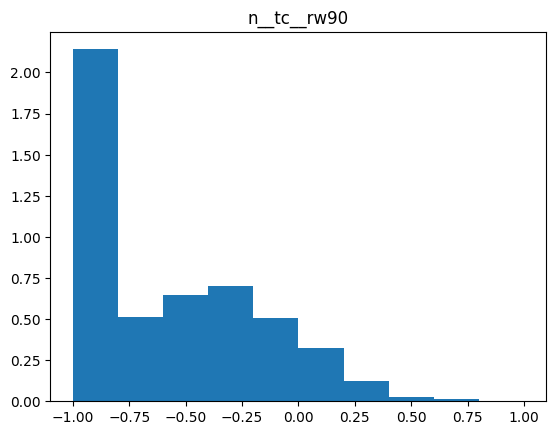

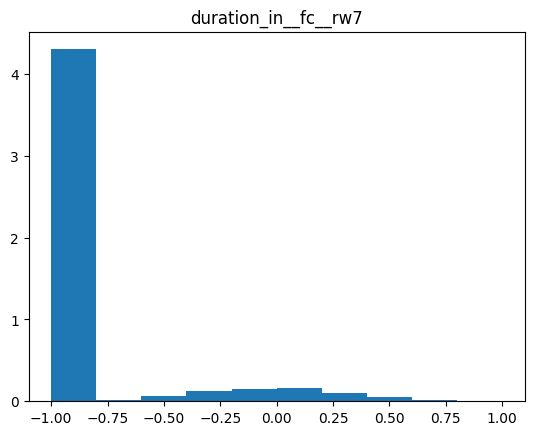

In [30]:
# df2 will contain log of the feature because the distributions are very skewed
df2 = df.copy()
for feature in train_columns:
    df2[feature] = np.log1p(df2[feature])

scaler = MinMaxScaler(feature_range=(-1,1))  # rescaling makes SVC MUCH MUCH faster while not imparting LGBM
scaler.fit(df2[train_columns])

df2[train_columns] = scaler.transform(df2[train_columns])

for feature in train_columns:
    plt.hist(df2[feature], density=True)
    plt.title(feature)
    plt.show()



In [31]:
# this column shows the % of the samples closed successfully
print(df2.groupby(['OpportunityId', 'CreatedDate__fq'], as_index=False).agg({'target': 'mean'}).target.astype(int).mean())

# and the number of rows that have target == 1
print(df2.target.mean())

0.07372100413091834
0.04103233526420277


In [74]:
# this identifies unique sets of Opportunities and FQs, because the target is the same for each pair (Opp, FQ)
unique_params = df2[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, test_size=0.5, stratify=unique_params['target'], random_state=SEED)

# next, we take only samples of this whole dataset to speed up model training/testing
# taking 0.2 * 0.5 = 0.1 for train 
train_params, _ = train_test_split(train_params, test_size=0.8, stratify=train_params['target'], random_state=SEED)
# taking 0.5*0.5 = 0.25 for test and 0.5*0.5=0.25 for validation for lgbm
test_params, val_params = train_test_split(test_params, test_size=0.5, stratify=test_params['target'], random_state=SEED)

In [75]:
train = []
test = []
val = []

df_shuffled = df2.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
val_params = set(list(val_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))


for name, group in grouped:
    #print(group.target.mean())
    if name in train_params:
        train.append(group)
    elif name in test_params:
        test.append(group)
    elif name in val_params:
        val.append(group)

train = pd.concat(train)
test = pd.concat(test)
val = pd.concat(val)


In [76]:
print(train[train_columns].shape, test[train_columns].shape, val[train_columns].shape)
print(f"Won in df2: {df2.target.mean():.4f}")
print(f"Won in train: {train.target.mean():.4f}")
print(f"Won in test: {test.target.mean():.4f}")
df2.shape

(17297, 9) (46921, 9) (46936, 9)
Won in df2: 0.0410
Won in train: 0.0356
Won in test: 0.0409


(183855, 72)

From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

In [77]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [78]:
print(train[train_columns].shape, test[train_columns].shape)
print(f"Won in train: {train.target.mean():.3f}")
print(f"Won in test: {test.target.mean():.3f}")

(18535, 9) (46921, 9)
Won in train: 0.100
Won in test: 0.041


## Candidate 1: SVC - Support Vector Classifier

In [89]:
# proceed with "standard" parameters
svc = SVC(kernel='poly', degree=3, class_weight='balanced', random_state=SEED, probability=True, tol=0.1, verbose=1)
svc.fit(train[train_columns], train.target)

[LibSVM]..................
*..................
*.......
*....
*..
*..
*.....
*
optimization finished, #iter = 54495
obj = -5179.387189, rho = -1.278615
nSV = 5595, nBSV = 5092
Total nSV = 5595
................
*....................
*......
*....
*..
*
optimization finished, #iter = 46251
obj = -5146.357011, rho = -1.321286
nSV = 5541, nBSV = 4998
Total nSV = 5541
..............
*...................
*...........
*.
*
optimization finished, #iter = 44189
obj = -5070.754909, rho = -1.273236
nSV = 5500, nBSV = 4933
Total nSV = 5500
.................
*................
*..............
*...
*...
*..
*.
*...
*
optimization finished, #iter = 56616
obj = -5022.662506, rho = -1.217749
nSV = 5419, nBSV = 4899
Total nSV = 5419
.............
*....................
*..........
*..
*..
*.
*..
*
optimization finished, #iter = 49643
obj = -5139.013445, rho = -1.238482
nSV = 5559, nBSV = 5063
Total nSV = 5559
.............
*......
*.
*.
*
optimization finished, #iter = 19870
obj = -6304.290283, rho = 1.29

SVC(class_weight='balanced', kernel='poly', probability=True, random_state=123,
    tol=0.1, verbose=1)

In [104]:
# get predictions 
test['svc_pred'] = svc.predict(test[train_columns])
test['svc_proba'] = svc.predict_proba(test[train_columns])[:, 1]
train['svc_pred'] = svc.predict(train[train_columns])
train['svc_proba'] = svc.predict_proba(train[train_columns])[:, 1]

## Candidate 2: LightGBM - Random Forest

In [92]:
trial_config = {
  'suggest_float':
    {
        'reg_alpha': {'name': 'reg_alpha', 'low': 1e-3, 'high': 10.0, 'log': True},
        'reg_lambda': {'name': 'reg_lambda', 'low': 1e-3, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.001, 'high': 0.1, 'log': True},
        'subsample': {'name': 'subsample', 'low': 0.2, 'high': 1},
        'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },

  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 2700},
    }
    
}

In [93]:
def objective_timecv_everyday(data: pd.DataFrame, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    def custom_time_split(x, y):
        groups = x.groupby('CreatedDate__fq')
        train_idx, test_idx = [], []
        for _, group in groups:
            test_idx = group.index
            if train_idx:
                yield train_idx, test_idx
            train_idx.extend(group.index)

    data = data.sort_values(by=['CreatedDate'], ascending=True)
    X, y = data, data.target  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    for train_idx, test_idx in tqdm(custom_time_split(X, y)):
        splits += 1
        # split the dataset into test and train using the custom function above
        x_train, y_train = X.loc[train_idx], y.loc[train_idx]
        x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # use the previously fitted model if possible
        boost = model if model.__sklearn_is_fitted__() else None
        
        model.fit(x_train[train_columns], y_train, init_model=boost)
        
        # generate predictions for the unseen quarter and save it
        y_pred = model.predict_proba(x_test[train_columns])[:, 1]
        metric = log_loss(y_test, y_pred, labels=[0, 1])
        avg_metric.append(metric)

    weights = (np.arange(splits) + 1) / np.sum(np.arange(splits))
    
    return np.dot(avg_metric, weights)


def objective_for_stratified(train_data: pd.DataFrame, val_data, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = train_data[train_columns], val_data[train_columns], train_data.target, val_data.target
        
    model.fit(x_train[train_columns], y_train)
        
    # generate predictions for the unseen quarter and save it
    y_proba = model.predict_proba(x_test[train_columns])[:, 1]
    y_pred = model.predict(x_test[train_columns])
    #metric = log_loss(y_test, y_proba, labels=[0, 1])
    metric = matthews_corrcoef(y_test, y_pred)
    print(metric)
    return metric


def get_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model


def optimize(train_data, val_data, objective, n_trials):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    LightGBMClassifier - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(train_data, val_data, trial), n_trials=n_trials)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(train_data[train_columns], train_data.target)
    return model

In [94]:
lgbm = optimize(train, val, objective_for_stratified, 40)

[I 2023-10-04 14:15:41,602] A new study created in memory with name: no-name-58891609-3dc2-4ae8-91bb-94e4b231051a
[I 2023-10-04 14:15:42,760] Trial 0 finished with value: 0.2561402146312502 and parameters: {'reg_alpha': 0.6107686573608484, 'reg_lambda': 0.013949458198611207, 'learning_rate': 0.002842515929299161, 'subsample': 0.6410518152663129, 'colsample_bytree': 0.7755751758284506, 'min_split_gain': 0.30194345748587803, 'min_child_weight': 0.3410134276028888, 'n_estimators': 688, 'num_leaves': 988, 'subsample_freq': 40, 'min_child_samples': 933}. Best is trial 0 with value: 0.2561402146312502.


0.2561402146312502


[I 2023-10-04 14:15:44,051] Trial 1 finished with value: 0.26919550007151927 and parameters: {'reg_alpha': 0.8245155098953619, 'reg_lambda': 0.05679223741740079, 'learning_rate': 0.0013163027639428412, 'subsample': 0.5184354042643451, 'colsample_bytree': 0.7903963245856287, 'min_split_gain': 0.13591929401291497, 'min_child_weight': 0.0004285364338531866, 'n_estimators': 536, 'num_leaves': 1092, 'subsample_freq': 64, 'min_child_samples': 2295}. Best is trial 1 with value: 0.26919550007151927.


0.26919550007151927


[I 2023-10-04 14:15:46,244] Trial 2 finished with value: 0.22585215226652333 and parameters: {'reg_alpha': 0.7903533518289985, 'reg_lambda': 0.27803152557785016, 'learning_rate': 0.02785394829873094, 'subsample': 0.45836713108254257, 'colsample_bytree': 0.4894309244978513, 'min_split_gain': 0.16750162930647938, 'min_child_weight': 0.0011428141666659053, 'n_estimators': 635, 'num_leaves': 194, 'subsample_freq': 44, 'min_child_samples': 1169}. Best is trial 1 with value: 0.26919550007151927.


0.22585215226652333


[I 2023-10-04 14:15:47,199] Trial 3 finished with value: 0.2624955675974549 and parameters: {'reg_alpha': 0.09434967110751795, 'reg_lambda': 0.05050346330980693, 'learning_rate': 0.004212330570736681, 'subsample': 0.5410810455702466, 'colsample_bytree': 0.9147113304937078, 'min_split_gain': 0.6614704125606768, 'min_child_weight': 0.006421637888702559, 'n_estimators': 628, 'num_leaves': 242, 'subsample_freq': 32, 'min_child_samples': 1126}. Best is trial 1 with value: 0.26919550007151927.


0.2624955675974549


[I 2023-10-04 14:15:51,361] Trial 4 finished with value: 0.2213246206826741 and parameters: {'reg_alpha': 2.919017048795458, 'reg_lambda': 0.010042028777169459, 'learning_rate': 0.009248440961286577, 'subsample': 0.988447828488564, 'colsample_bytree': 0.6155880954078474, 'min_split_gain': 0.43289722277644765, 'min_child_weight': 0.000271964170014466, 'n_estimators': 828, 'num_leaves': 1237, 'subsample_freq': 55, 'min_child_samples': 932}. Best is trial 1 with value: 0.26919550007151927.


0.2213246206826741


[I 2023-10-04 14:15:55,870] Trial 5 finished with value: 0.12293336182494095 and parameters: {'reg_alpha': 0.01646202117975735, 'reg_lambda': 0.04656813487239959, 'learning_rate': 0.023046317016688342, 'subsample': 0.9003654734361399, 'colsample_bytree': 0.6083378699824089, 'min_split_gain': 0.4718265102439678, 'min_child_weight': 0.012899670390371517, 'n_estimators': 629, 'num_leaves': 1384, 'subsample_freq': 85, 'min_child_samples': 233}. Best is trial 1 with value: 0.26919550007151927.


0.12293336182494095


[I 2023-10-04 14:15:57,323] Trial 6 finished with value: 0.27224068797926015 and parameters: {'reg_alpha': 1.1343089682264835, 'reg_lambda': 0.009433340226357022, 'learning_rate': 0.0024459406857737266, 'subsample': 0.6579655659931785, 'colsample_bytree': 0.2765700132899097, 'min_split_gain': 0.6208755101298463, 'min_child_weight': 0.018171401605983295, 'n_estimators': 726, 'num_leaves': 39, 'subsample_freq': 60, 'min_child_samples': 1508}. Best is trial 6 with value: 0.27224068797926015.


0.27224068797926015


[I 2023-10-04 14:16:07,795] Trial 7 finished with value: 0.08183735399676628 and parameters: {'reg_alpha': 0.00432353099339218, 'reg_lambda': 0.004095265478887798, 'learning_rate': 0.024607022000237334, 'subsample': 0.4550131411055011, 'colsample_bytree': 0.7535762364254557, 'min_split_gain': 0.39252444230526273, 'min_child_weight': 0.0025178120149185962, 'n_estimators': 926, 'num_leaves': 1724, 'subsample_freq': 36, 'min_child_samples': 127}. Best is trial 6 with value: 0.27224068797926015.


0.08183735399676628


[I 2023-10-04 14:16:12,485] Trial 8 finished with value: 0.1810124652000573 and parameters: {'reg_alpha': 0.01656045609634458, 'reg_lambda': 0.03915098813009525, 'learning_rate': 0.02569908500486021, 'subsample': 0.996286785627214, 'colsample_bytree': 0.48473189257396765, 'min_split_gain': 0.5361579915119493, 'min_child_weight': 0.013698052895750504, 'n_estimators': 695, 'num_leaves': 315, 'subsample_freq': 40, 'min_child_samples': 658}. Best is trial 6 with value: 0.27224068797926015.


0.1810124652000573


[I 2023-10-04 14:16:15,606] Trial 9 finished with value: 0.23188202343894548 and parameters: {'reg_alpha': 0.023649613970098012, 'reg_lambda': 0.11285287222175328, 'learning_rate': 0.021540168700541894, 'subsample': 0.2847267880454511, 'colsample_bytree': 0.3047159605312646, 'min_split_gain': 0.23216661846313255, 'min_child_weight': 0.024154298486922587, 'n_estimators': 848, 'num_leaves': 1136, 'subsample_freq': 86, 'min_child_samples': 1045}. Best is trial 6 with value: 0.27224068797926015.


0.23188202343894548


[I 2023-10-04 14:16:15,945] Trial 10 finished with value: 0.2289332943555343 and parameters: {'reg_alpha': 8.658029726346374, 'reg_lambda': 0.0011284565964041345, 'learning_rate': 0.09216114621473025, 'subsample': 0.7684482288021226, 'colsample_bytree': 0.23718730879480437, 'min_split_gain': 0.014452828211682034, 'min_child_weight': 0.00010323458726232756, 'n_estimators': 248, 'num_leaves': 667, 'subsample_freq': 5, 'min_child_samples': 2084}. Best is trial 6 with value: 0.27224068797926015.


0.2289332943555343


[I 2023-10-04 14:16:16,973] Trial 11 finished with value: 0.26919550007151927 and parameters: {'reg_alpha': 0.49392768505436674, 'reg_lambda': 1.7732414383823514, 'learning_rate': 0.0010105270489181924, 'subsample': 0.6727751965823945, 'colsample_bytree': 0.9642382376729233, 'min_split_gain': 0.6859904204203392, 'min_child_weight': 0.0007793507972086505, 'n_estimators': 362, 'num_leaves': 1993, 'subsample_freq': 67, 'min_child_samples': 2099}. Best is trial 6 with value: 0.27224068797926015.


0.26919550007151927


[I 2023-10-04 14:16:18,156] Trial 12 finished with value: 0.292656511296401 and parameters: {'reg_alpha': 1.360196679087643, 'reg_lambda': 0.4674514341208533, 'learning_rate': 0.0010170803688691846, 'subsample': 0.7525627089123014, 'colsample_bytree': 0.20487632567397535, 'min_split_gain': 0.5629391808758364, 'min_child_weight': 0.039862624509600486, 'n_estimators': 29, 'num_leaves': 695, 'subsample_freq': 68, 'min_child_samples': 2493}. Best is trial 12 with value: 0.292656511296401.


0.292656511296401


[I 2023-10-04 14:16:18,996] Trial 13 finished with value: 0.29250417995427924 and parameters: {'reg_alpha': 3.7592805354225782, 'reg_lambda': 8.246602215031004, 'learning_rate': 0.0020355981997190113, 'subsample': 0.791130542868163, 'colsample_bytree': 0.22303595589560973, 'min_split_gain': 0.5795295805659868, 'min_child_weight': 0.05230890926517021, 'n_estimators': 87, 'num_leaves': 653, 'subsample_freq': 74, 'min_child_samples': 1708}. Best is trial 12 with value: 0.292656511296401.


0.29250417995427924


[I 2023-10-04 14:16:19,258] Trial 14 finished with value: 0.27692807069097486 and parameters: {'reg_alpha': 8.059094112218803, 'reg_lambda': 7.775678013711436, 'learning_rate': 0.0016238300435642285, 'subsample': 0.8298718511659723, 'colsample_bytree': 0.20286447995538226, 'min_split_gain': 0.5459858588734392, 'min_child_weight': 0.07254844721324151, 'n_estimators': 16, 'num_leaves': 660, 'subsample_freq': 75, 'min_child_samples': 2628}. Best is trial 12 with value: 0.292656511296401.


0.27692807069097486


[I 2023-10-04 14:16:19,529] Trial 15 finished with value: 0.2708385783651429 and parameters: {'reg_alpha': 3.482445839095889, 'reg_lambda': 0.9364210171915481, 'learning_rate': 0.0017911315537233316, 'subsample': 0.7655472246107734, 'colsample_bytree': 0.3560695538461459, 'min_split_gain': 0.5763843682761023, 'min_child_weight': 0.07202039728013475, 'n_estimators': 28, 'num_leaves': 654, 'subsample_freq': 100, 'min_child_samples': 1760}. Best is trial 12 with value: 0.292656511296401.


0.2708385783651429


[I 2023-10-04 14:16:20,352] Trial 16 finished with value: 0.2706063308827026 and parameters: {'reg_alpha': 0.20651728101107875, 'reg_lambda': 9.1669112251074, 'learning_rate': 0.0010016340502272568, 'subsample': 0.855010943884567, 'colsample_bytree': 0.37453573873651075, 'min_split_gain': 0.5069268298198207, 'min_child_weight': 0.06368744714396957, 'n_estimators': 235, 'num_leaves': 846, 'subsample_freq': 81, 'min_child_samples': 2668}. Best is trial 12 with value: 0.292656511296401.


0.2706063308827026


[I 2023-10-04 14:16:21,265] Trial 17 finished with value: 0.2904404051471083 and parameters: {'reg_alpha': 3.9484739186662767, 'reg_lambda': 1.7706124189926171, 'learning_rate': 0.0033199565202328206, 'subsample': 0.7419024039740062, 'colsample_bytree': 0.20849639372154383, 'min_split_gain': 0.6126166376223646, 'min_child_weight': 0.2684481441266319, 'n_estimators': 134, 'num_leaves': 468, 'subsample_freq': 99, 'min_child_samples': 1675}. Best is trial 12 with value: 0.292656511296401.


0.2904404051471083


[I 2023-10-04 14:16:22,656] Trial 18 finished with value: 0.27879553111449906 and parameters: {'reg_alpha': 1.5869501901855496, 'reg_lambda': 0.32325260562955227, 'learning_rate': 0.001990166429116272, 'subsample': 0.8987670433134665, 'colsample_bytree': 0.36334187379773797, 'min_split_gain': 0.37879571707228044, 'min_child_weight': 0.003430486356814861, 'n_estimators': 386, 'num_leaves': 1414, 'subsample_freq': 14, 'min_child_samples': 2337}. Best is trial 12 with value: 0.292656511296401.


0.27879553111449906


[I 2023-10-04 14:16:23,293] Trial 19 finished with value: 0.28705878407767355 and parameters: {'reg_alpha': 0.28680715127487183, 'reg_lambda': 4.390950219902835, 'learning_rate': 0.005493517750527712, 'subsample': 0.6990221354401837, 'colsample_bytree': 0.44852256348686936, 'min_split_gain': 0.47195194984875766, 'min_child_weight': 0.11756364210564393, 'n_estimators': 131, 'num_leaves': 835, 'subsample_freq': 72, 'min_child_samples': 1889}. Best is trial 12 with value: 0.292656511296401.


0.28705878407767355


[I 2023-10-04 14:16:24,582] Trial 20 finished with value: 0.27540497081754095 and parameters: {'reg_alpha': 0.0010012500531856783, 'reg_lambda': 3.1614546458470874, 'learning_rate': 0.0016178107011764254, 'subsample': 0.5956250270551854, 'colsample_bytree': 0.28996584404442793, 'min_split_gain': 0.6915127016950722, 'min_child_weight': 0.031591678874063, 'n_estimators': 370, 'num_leaves': 479, 'subsample_freq': 26, 'min_child_samples': 1460}. Best is trial 12 with value: 0.292656511296401.


0.27540497081754095


[I 2023-10-04 14:16:25,609] Trial 21 finished with value: 0.29400604255522783 and parameters: {'reg_alpha': 3.202290487683155, 'reg_lambda': 1.2399372827402988, 'learning_rate': 0.0031355059668671343, 'subsample': 0.749119523580479, 'colsample_bytree': 0.20243700429721145, 'min_split_gain': 0.6039483852866068, 'min_child_weight': 0.31371431863816396, 'n_estimators': 118, 'num_leaves': 415, 'subsample_freq': 90, 'min_child_samples': 1688}. Best is trial 21 with value: 0.29400604255522783.


0.29400604255522783


[I 2023-10-04 14:16:26,116] Trial 22 finished with value: 0.2883133725699059 and parameters: {'reg_alpha': 1.9762285810318714, 'reg_lambda': 0.8265233923723035, 'learning_rate': 0.0025559740201004603, 'subsample': 0.7798271141748249, 'colsample_bytree': 0.2065829025100118, 'min_split_gain': 0.5905992255797494, 'min_child_weight': 0.1756513260874044, 'n_estimators': 123, 'num_leaves': 874, 'subsample_freq': 91, 'min_child_samples': 1955}. Best is trial 21 with value: 0.29400604255522783.


0.2883133725699059


[I 2023-10-04 14:16:27,024] Trial 23 finished with value: 0.2692174975914246 and parameters: {'reg_alpha': 4.723701836832269, 'reg_lambda': 3.6479054204732004, 'learning_rate': 0.0013209391019105058, 'subsample': 0.7161910089626826, 'colsample_bytree': 0.2869928562228283, 'min_split_gain': 0.5379682879863562, 'min_child_weight': 0.16785722293954236, 'n_estimators': 211, 'num_leaves': 506, 'subsample_freq': 78, 'min_child_samples': 2280}. Best is trial 21 with value: 0.29400604255522783.


0.2692174975914246


[I 2023-10-04 14:16:27,895] Trial 24 finished with value: 0.2752665311953847 and parameters: {'reg_alpha': 1.6102681366948177, 'reg_lambda': 0.5900511070386895, 'learning_rate': 0.004758075162687782, 'subsample': 0.8248646327208364, 'colsample_bytree': 0.2624229855661643, 'min_split_gain': 0.6202388453145107, 'min_child_weight': 0.03571943415468719, 'n_estimators': 73, 'num_leaves': 341, 'subsample_freq': 91, 'min_child_samples': 1348}. Best is trial 21 with value: 0.29400604255522783.


0.2752665311953847


[I 2023-10-04 14:16:29,899] Trial 25 finished with value: 0.2791513720711252 and parameters: {'reg_alpha': 8.957427373261188, 'reg_lambda': 1.8638801565073946, 'learning_rate': 0.002082483079595037, 'subsample': 0.7344098870778412, 'colsample_bytree': 0.35466515679182986, 'min_split_gain': 0.5071214401190307, 'min_child_weight': 0.3737852713528766, 'n_estimators': 288, 'num_leaves': 25, 'subsample_freq': 51, 'min_child_samples': 1644}. Best is trial 21 with value: 0.29400604255522783.


0.2791513720711252


[I 2023-10-04 14:16:30,880] Trial 26 finished with value: 0.26470053798383025 and parameters: {'reg_alpha': 2.2814089316677073, 'reg_lambda': 7.765138289321812, 'learning_rate': 0.0032442143622526554, 'subsample': 0.7999095510745322, 'colsample_bytree': 0.21037120097832934, 'min_split_gain': 0.6508004498151316, 'min_child_weight': 0.04974212755167212, 'n_estimators': 190, 'num_leaves': 709, 'subsample_freq': 70, 'min_child_samples': 592}. Best is trial 21 with value: 0.29400604255522783.


0.26470053798383025


[I 2023-10-04 14:16:31,888] Trial 27 finished with value: 0.2827373306376054 and parameters: {'reg_alpha': 4.82101762542052, 'reg_lambda': 0.4324482313372812, 'learning_rate': 0.0014558191436021876, 'subsample': 0.8821292468978111, 'colsample_bytree': 0.31277394917632123, 'min_split_gain': 0.5792161567844117, 'min_child_weight': 0.1170612189141048, 'n_estimators': 307, 'num_leaves': 530, 'subsample_freq': 59, 'min_child_samples': 2518}. Best is trial 21 with value: 0.29400604255522783.


0.2827373306376054


[I 2023-10-04 14:16:32,624] Trial 28 finished with value: 0.25491275748709585 and parameters: {'reg_alpha': 1.280588479576637, 'reg_lambda': 0.2126619079743911, 'learning_rate': 0.0022049618967775013, 'subsample': 0.7045433025046774, 'colsample_bytree': 0.42806055694143486, 'min_split_gain': 0.44475248958731406, 'min_child_weight': 0.10748370241962489, 'n_estimators': 64, 'num_leaves': 923, 'subsample_freq': 81, 'min_child_samples': 1348}. Best is trial 21 with value: 0.29400604255522783.


0.25491275748709585


[I 2023-10-04 14:16:34,006] Trial 29 finished with value: 0.2861942878623321 and parameters: {'reg_alpha': 0.6206792057235491, 'reg_lambda': 1.0593479679245557, 'learning_rate': 0.002921242699361399, 'subsample': 0.6208618277825761, 'colsample_bytree': 0.2571048277869803, 'min_split_gain': 0.3310267641391649, 'min_child_weight': 0.3629299566994369, 'n_estimators': 475, 'num_leaves': 999, 'subsample_freq': 89, 'min_child_samples': 1936}. Best is trial 21 with value: 0.29400604255522783.


0.2861942878623321


[I 2023-10-04 14:16:34,576] Trial 30 finished with value: 0.2684516492425411 and parameters: {'reg_alpha': 2.3716388747694, 'reg_lambda': 0.17240518963360227, 'learning_rate': 0.001032918033249237, 'subsample': 0.6544900335069073, 'colsample_bytree': 0.3272039576781907, 'min_split_gain': 0.6948059918352754, 'min_child_weight': 0.050702615395578146, 'n_estimators': 160, 'num_leaves': 380, 'subsample_freq': 48, 'min_child_samples': 2144}. Best is trial 21 with value: 0.29400604255522783.


0.2684516492425411


[I 2023-10-04 14:16:34,951] Trial 31 finished with value: 0.29226046116441984 and parameters: {'reg_alpha': 6.177027565373175, 'reg_lambda': 1.7980021971009288, 'learning_rate': 0.003472498679528182, 'subsample': 0.7379320476796689, 'colsample_bytree': 0.24164062460334912, 'min_split_gain': 0.622786404651746, 'min_child_weight': 0.25015550946016535, 'n_estimators': 103, 'num_leaves': 521, 'subsample_freq': 100, 'min_child_samples': 1695}. Best is trial 21 with value: 0.29400604255522783.


0.29226046116441984


[I 2023-10-04 14:16:35,733] Trial 32 finished with value: 0.2938410575106197 and parameters: {'reg_alpha': 5.47203545354114, 'reg_lambda': 0.6308261783457817, 'learning_rate': 0.003467843162880895, 'subsample': 0.7937417320651332, 'colsample_bytree': 0.25126714757129065, 'min_split_gain': 0.6395954124491003, 'min_child_weight': 0.21901864790739828, 'n_estimators': 83, 'num_leaves': 176, 'subsample_freq': 97, 'min_child_samples': 1780}. Best is trial 21 with value: 0.29400604255522783.


0.2938410575106197


[I 2023-10-04 14:16:36,304] Trial 33 finished with value: 0.28423710106761524 and parameters: {'reg_alpha': 3.9952739334390968, 'reg_lambda': 0.3779498713892446, 'learning_rate': 0.0013734662755066748, 'subsample': 0.8176188676444504, 'colsample_bytree': 0.2580440059811443, 'min_split_gain': 0.5728164274403829, 'min_child_weight': 0.1907620826231002, 'n_estimators': 14, 'num_leaves': 158, 'subsample_freq': 95, 'min_child_samples': 2474}. Best is trial 21 with value: 0.29400604255522783.


0.28423710106761524


[I 2023-10-04 14:16:37,168] Trial 34 finished with value: 0.28580028572335875 and parameters: {'reg_alpha': 0.9626623622378797, 'reg_lambda': 0.493246415164744, 'learning_rate': 0.0024207075617371527, 'subsample': 0.8043048846135481, 'colsample_bytree': 0.20083735031207095, 'min_split_gain': 0.6427679524701068, 'min_child_weight': 0.36394551908577816, 'n_estimators': 84, 'num_leaves': 126, 'subsample_freq': 75, 'min_child_samples': 1554}. Best is trial 21 with value: 0.29400604255522783.


0.28580028572335875


[I 2023-10-04 14:16:42,609] Trial 35 finished with value: 0.2559326234579102 and parameters: {'reg_alpha': 2.866066950933406, 'reg_lambda': 0.8015912793073527, 'learning_rate': 0.005687897276241704, 'subsample': 0.9415387762126113, 'colsample_bytree': 0.3963223081308501, 'min_split_gain': 0.6626476202300182, 'min_child_weight': 0.11955183822066105, 'n_estimators': 452, 'num_leaves': 737, 'subsample_freq': 65, 'min_child_samples': 1837}. Best is trial 21 with value: 0.29400604255522783.


0.2559326234579102


[I 2023-10-04 14:16:43,640] Trial 36 finished with value: 0.2874026718928573 and parameters: {'reg_alpha': 5.6866271099665475, 'reg_lambda': 0.2448254155305238, 'learning_rate': 0.0037335619111436716, 'subsample': 0.8603980563580209, 'colsample_bytree': 0.3324088989327828, 'min_split_gain': 0.5966596536149247, 'min_child_weight': 0.22049219990094684, 'n_estimators': 187, 'num_leaves': 264, 'subsample_freq': 83, 'min_child_samples': 1283}. Best is trial 21 with value: 0.29400604255522783.


0.2874026718928573


[I 2023-10-04 14:16:44,691] Trial 37 finished with value: 0.27761016070962335 and parameters: {'reg_alpha': 0.8295363156225726, 'reg_lambda': 0.12832970339452002, 'learning_rate': 0.001940786452114147, 'subsample': 0.7566344388890619, 'colsample_bytree': 0.29625893431840805, 'min_split_gain': 0.6542309871429073, 'min_child_weight': 0.04022117074448004, 'n_estimators': 293, 'num_leaves': 211, 'subsample_freq': 93, 'min_child_samples': 2265}. Best is trial 21 with value: 0.29400604255522783.


0.27761016070962335


[I 2023-10-04 14:16:48,304] Trial 38 finished with value: 0.24923092953366366 and parameters: {'reg_alpha': 2.4202507008652967, 'reg_lambda': 4.985627576123088, 'learning_rate': 0.0070687051422435605, 'subsample': 0.9520687903762594, 'colsample_bytree': 0.5613911595671244, 'min_split_gain': 0.5534491797138809, 'min_child_weight': 0.08317793929411621, 'n_estimators': 542, 'num_leaves': 1109, 'subsample_freq': 61, 'min_child_samples': 851}. Best is trial 21 with value: 0.29400604255522783.


0.24923092953366366


[I 2023-10-04 14:16:48,716] Trial 39 finished with value: 0.28247357795785416 and parameters: {'reg_alpha': 9.926728338356064, 'reg_lambda': 2.7085079728040093, 'learning_rate': 0.0041887703103353135, 'subsample': 0.8517723413537419, 'colsample_bytree': 0.2506885573682665, 'min_split_gain': 0.49815483542754624, 'min_child_weight': 0.02324429305588846, 'n_estimators': 68, 'num_leaves': 407, 'subsample_freq': 85, 'min_child_samples': 1242}. Best is trial 21 with value: 0.29400604255522783.


0.28247357795785416


In [98]:
test['lgbm_pred'] = lgbm.predict(test[train_columns])
test['lgbm_proba'] = lgbm.predict_proba(test[train_columns])[:, 1]
train['lgbm_pred'] = lgbm.predict(train[train_columns])
train['lgbm_proba'] = lgbm.predict_proba(train[train_columns])[:, 1]

## Let's compare 'em

SVC  F1=0.2876 Precision=0.1793 Recall=0.7266 MattScore=0.3114 
LGBM F1=0.2974 Precision=0.1867 Recall=0.7312 MattScore=0.3215 

[Train] SVC F1=0.5223 Precision=0.3724 Recall=0.8737 MattScore=0.5028 
[Train] LGBM F1=0.4735 Precision=0.3389 Recall=0.7852 MattScore=0.4374 


<Figure size 640x480 with 0 Axes>

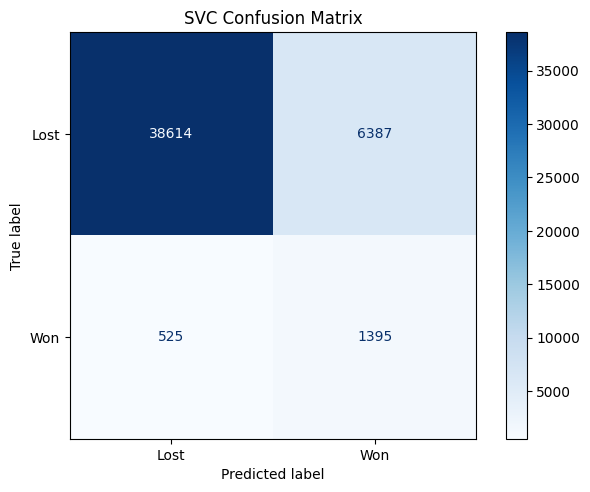

<Figure size 640x480 with 0 Axes>

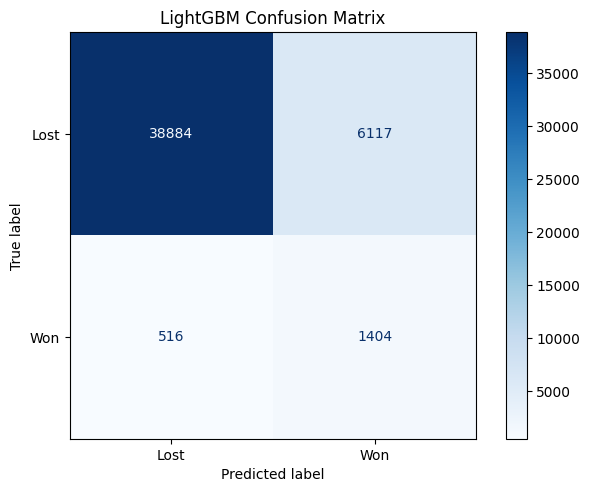

<Figure size 640x480 with 0 Axes>

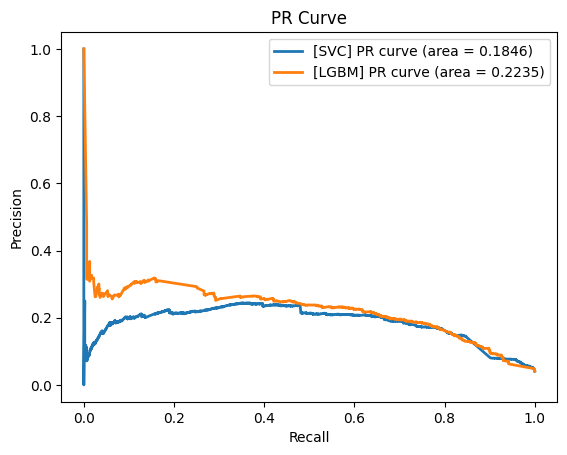

<Figure size 640x480 with 0 Axes>

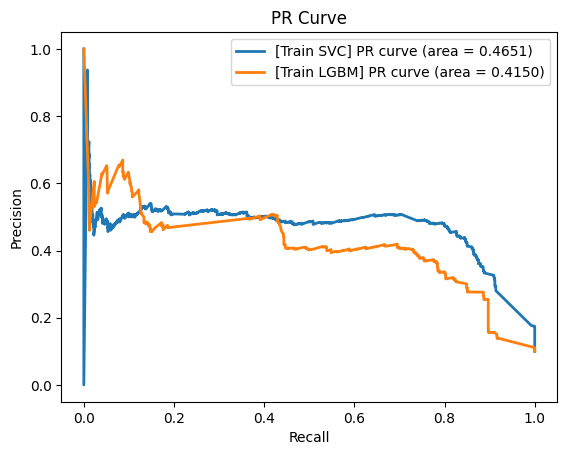

In [105]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = precision_recall_curve(y_true, pred)
            pr_auc = auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)
print(
    f"SVC  "
    f"F1={f1_score(test.target, test.svc_pred):.4f} "
    f"Precision={precision_score(test.target, test.svc_pred):.4f} "
    f"Recall={recall_score(test.target, test.svc_pred):.4f} "
    f"MattScore={matthews_corrcoef(test.target, test.svc_pred):.4f} "
)
print(
    f"LGBM "
    f"F1={f1_score(test.target, test.lgbm_pred):.4f} "
    f"Precision={precision_score(test.target, test.lgbm_pred):.4f} " 
    f"Recall={recall_score(test.target, test.lgbm_pred):.4f} "
    f"MattScore={matthews_corrcoef(test.target, test.lgbm_pred):.4f} "
)
print()
print(
    f"[Train] SVC "
    f"F1={f1_score(train.target, train.svc_pred):.4f} "
    f"Precision={precision_score(train.target, train.svc_pred):.4f} " 
    f"Recall={recall_score(train.target, train.svc_pred):.4f} "
    f"MattScore={matthews_corrcoef(train.target, train.svc_pred):.4f} "
)
print(
    f"[Train] LGBM "
    f"F1={f1_score(train.target, train.lgbm_pred):.4f} "
    f"Precision={precision_score(train.target, train.lgbm_pred):.4f} " 
    f"Recall={recall_score(train.target, train.lgbm_pred):.4f} "
    f"MattScore={matthews_corrcoef(train.target, train.lgbm_pred):.4f} "
)
plot_confusion_matrix(test.target.astype(int), test.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(test.target.astype(int), test.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(test.target.astype(int), [test.svc_proba, test.lgbm_proba], labels=['SVC', 'LGBM'])
plot_pr_auc(train.target.astype(int), [train.svc_proba, train.lgbm_proba], labels=['Train SVC', 'Train LGBM'])
